In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import matplotlib.pyplot as plt
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [21]:
import tensorflow as tf

In [22]:
base_bone_dir = os.path.join(r'C:\Users\nshetty\Downloads', 'input', 'rsna-bone-age')
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
# we don't want normalization for now
boneage_mean = 0
boneage_div = 1.0
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)


12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
6854,9175,82,False,C:\Users\nshetty\Downloads\input\rsna-bone-age...,True,female,82.0
6727,9033,106,False,C:\Users\nshetty\Downloads\input\rsna-bone-age...,True,female,106.0
6496,8787,72,True,C:\Users\nshetty\Downloads\input\rsna-bone-age...,True,male,72.0


C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\lib\histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

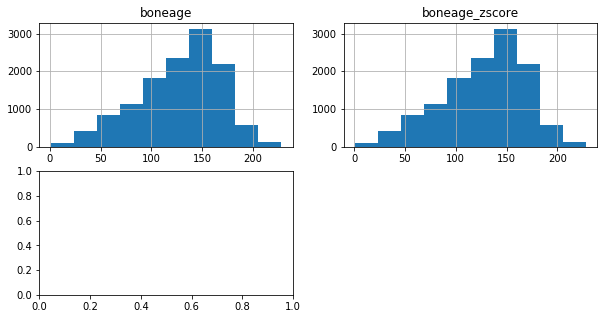

In [23]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

In [19]:
age_df

NameError: name 'age_df' is not defined

In [24]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = age_df['gender'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 9458 validation 3153


New Data Size: 10000 Old Size: 9458


C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\lib\histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

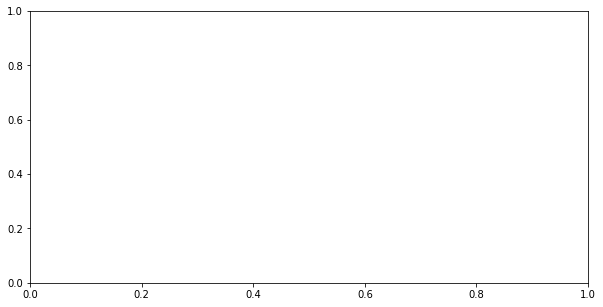

In [25]:
train_df = raw_train_df.groupby(['male']).apply(lambda x: x.sample(5000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df['male'].hist(figsize = (10, 5))

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)

In [27]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [28]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images


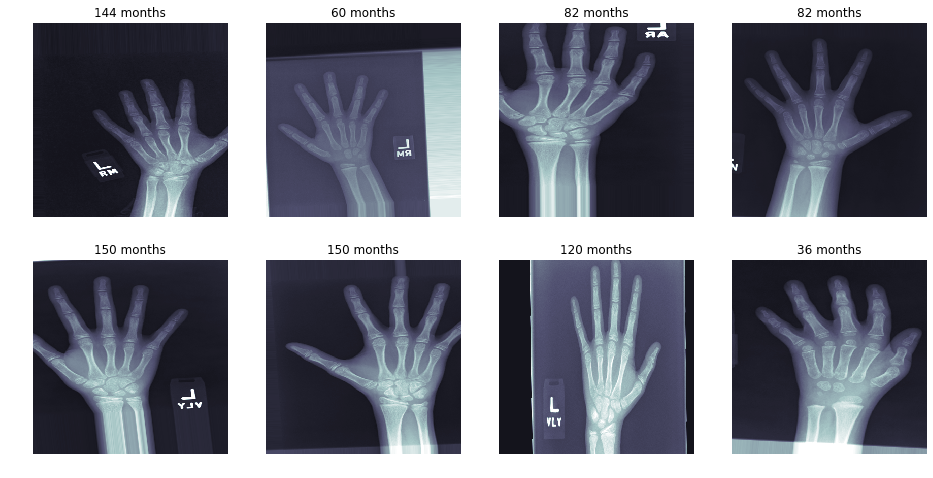

In [29]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

In [30]:
from keras import metrics

In [79]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_iv3_model = InceptionV3(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_iv3_model.trainable = False
bone_age_model = Sequential()
bone_age_model.add(base_iv3_model)
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1024, activation = 'tanh'))
bone_age_model.add(Dropout(0.25))
bone_age_model.add(Dense(1, activation = 'linear')) # linear is what 16bit did
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = ['mae'])

bone_age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
________________________________________________________

In [32]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = ['mae'])

bone_age_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 12, 12, 512)  14714688    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 12, 12, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 12, 12, 64)   32832       batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_5 (

In [80]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [33]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
bone_age_model.fit_generator(train_gen, 
                                  steps_per_epoch=313,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 15, 
                                  callbacks = callbacks_list)

Epoch 1/15
313/313 [==============================] - 4409s 14s/step - loss: 3640.6114 - mean_absolute_error: 43.1491 - val_loss: 753.2047 - val_mean_absolute_error: 22.3485

Epoch 00001: val_loss improved from inf to 753.20466, saving model to bone_age_weights.best.hdf5
Epoch 2/15
313/313 [==============================] - 4420s 14s/step - loss: 876.1400 - mean_absolute_error: 23.5818 - val_loss: 548.0964 - val_mean_absolute_error: 19.0921

Epoch 00002: val_loss improved from 753.20466 to 548.09640, saving model to bone_age_weights.best.hdf5
Epoch 3/15
313/313 [==============================] - 4411s 14s/step - loss: 746.9784 - mean_absolute_error: 21.8650 - val_loss: 520.7791 - val_mean_absolute_error: 18.4203

Epoch 00003: val_loss improved from 548.09640 to 520.77908, saving model to bone_age_weights.best.hdf5
Epoch 4/15
313/313 [==============================] - 4434s 14s/step - loss: 656.5843 - mean_absolute_error: 20.3983 - val_loss: 490.5586 - val_mean_absolute_error: 17.8506



In [10]:
#import cv2
import os

In [4]:
from keras.models import load_model

In [5]:
model = load_model('general_weights.h5')

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = ['mae'])

In [93]:
#img = cv2.imread(r':\Users\nshetty\Downloads\input\rsna-bone-age\boneage-test-dataset.zip\boneage-test-dataset\4360.png')

In [18]:
#img = cv2.resize(img,(224,224))
#img = np.reshape(img,[1,224,224,3])

In [14]:
from keras.preprocessing import image
import numpy as np

In [8]:
folder_path = 'C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'


In [1]:
from keras.preprocessing.image import img_to_array, array_to_img

Using TensorFlow backend.


In [15]:
images = []
for img in os.listdir(folder_path):
    img = image.load_img(r'C:\Users\nshetty\Downloads\input\rsna-bone-age\boneage-test-dataset\boneage-test-dataset\4360.png', target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

In [98]:
#img = image.load_img(r'C:\Users\nshetty\Downloads\input\rsna-bone-age\boneage-test-dataset\boneage-test-dataset\4360.png', target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)

#images = np.vstack([x])
#classes = model.predict(images)

# Predicting Test Set

In [16]:
images = np.vstack(images)
classes = model.predict(images)

In [ ]:
classes

In [63]:
for attn_layer in bone_age_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

IndexError: too many indices for array

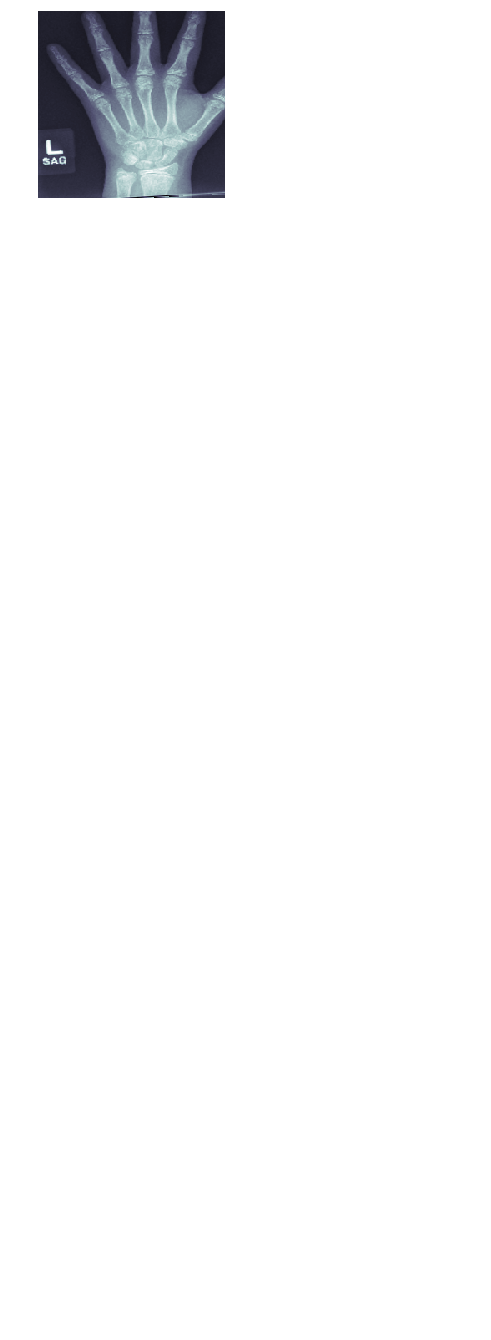

In [65]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [bone_age_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_age = boneage_div*test_Y[c_idx]+boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age/12))
    pred_age = boneage_div*bone_age_model.predict(cur_img)+boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age/12))
fig.savefig('attention_map.png', dpi = 300)

In [66]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

1024/1024 [==============================] - 397s 388ms/step


In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

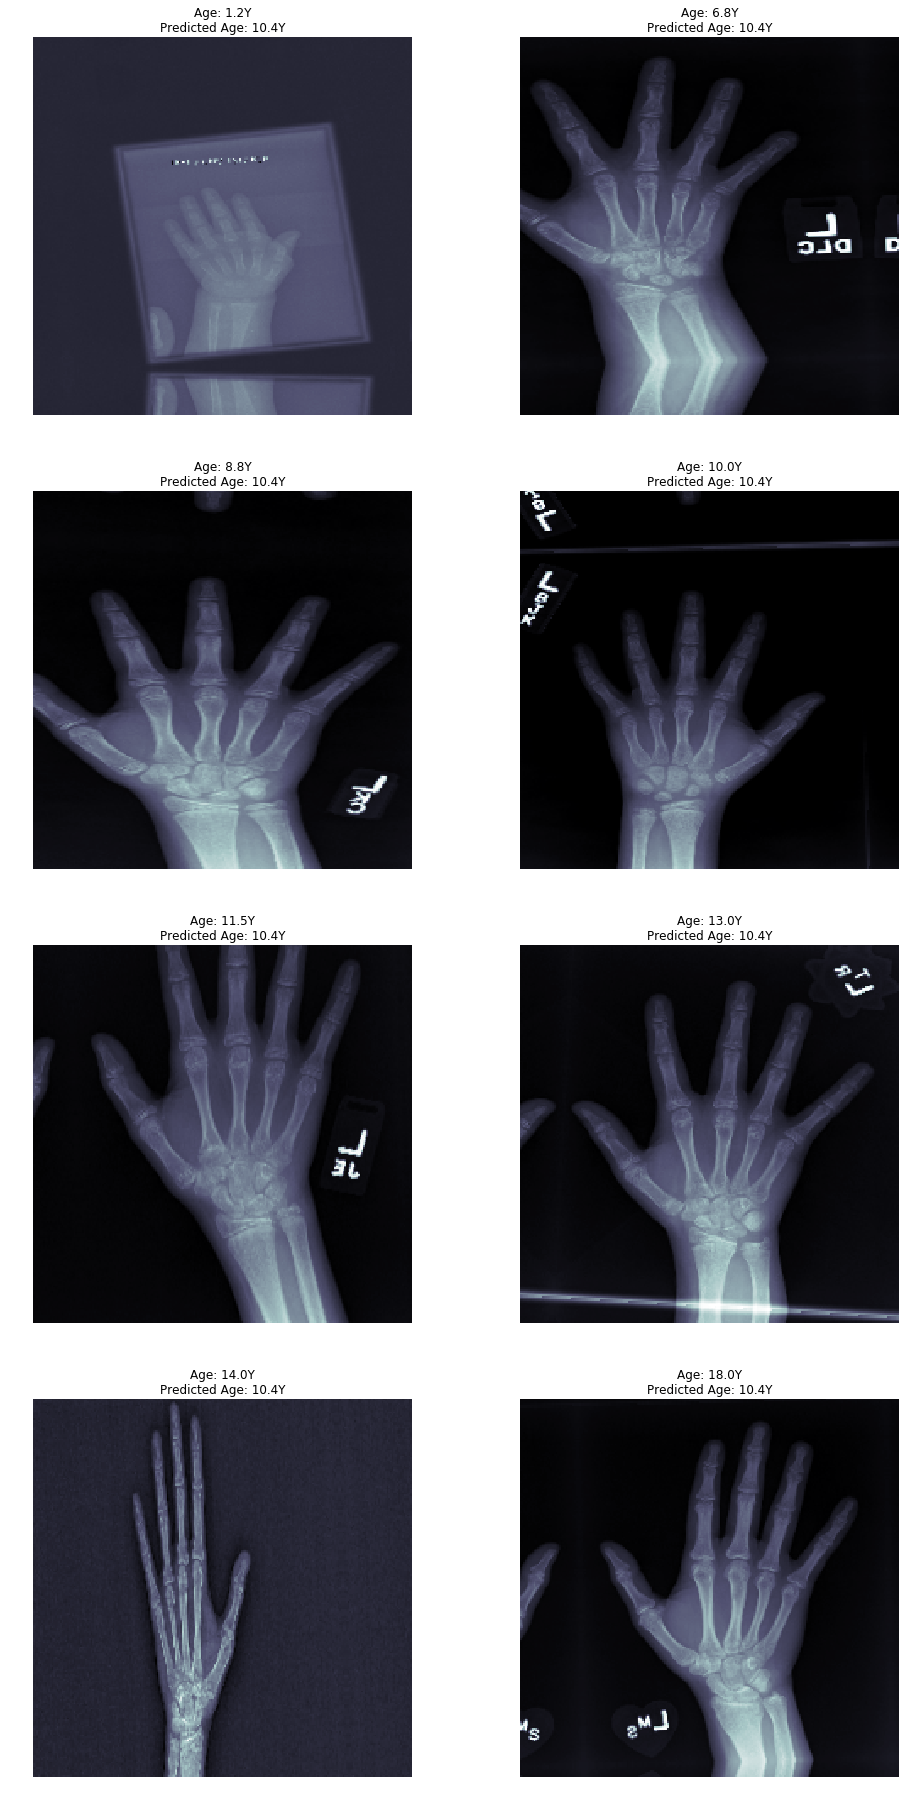

In [68]:
ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           pred_Y[idx]/12.0))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)